# Домашнее задание 2. Нейронные сети
## Першаев Никита ИУ8-83

В зависимости от варианта, для решения задачи используйте следующие наборы данных:

<table>
    <thead>
         <tr>
            <th colspan=1>Задача классификации</th>
            <th colspan=5>Задача регрессии</th>
        </tr>
        <tr>
            <th> </th>
            <th>A</th>
            <th>B</th>
            <th>C</th>
            <th>D</th>
            <th>E</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>K</td>
            <td>1</td>
            <td>2</td>
            <td>3</td>
            <td>4</td>
            <td>5</td>
        </tr>
        <tr>
            <td>L</td>
            <td>6</td>
            <td>7</td>
            <td>8</td>
            <td>9</td>
            <td>10</td>
        </tr>
        <tr>
            <td>M</td>
            <td>11</td>
            <td>12</td>
            <td>13</td>
            <td>14</td>
            <td>15</td>
        </tr>
        <tr>
            <td>N</td>
            <td>16</td>
            <td>17</td>
            <td>18</td>
            <td>19</td>
            <td>20</td>
        </tr>
        <tr>
            <td>O</td>
            <td>21</td>
            <td>22</td>
            <td>23</td>
            <td>24</td>
            <td>25</td>
        </tr>
    </tbody>
</table>

### Наборы данных

**Задача классификации**

L. [Набор данных](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) Таблица `WA_Fn-UseC_-HR-Employee-Attrition.csv`. Задача: предсказать увольнение сотрудника (колонка `attrition`). Baseline: sklearn.metrics.f1_score(average='macro') = 0.70


# 0. Инициализация библиотек

In [1]:
import pandas as pd
import numpy as np
import torch
import math
import matplotlib.pyplot as plt

from torch import nn
from torch.nn import functional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score

# 2. Искусственная неронная сеть для решения задачи классификации (9 баллов)

## 2.1 Загрузите данные, поделить на train и test

In [2]:
classificationBaseline = 0.70
emoloyeeAttrition = pd.read_csv('../data/Employee-Attrition.csv')

## 2.2 По необходимости проведите преодбработку/нормализацию данных

In [3]:
# Categorical features into numerical
columnsToDummy = ['BusinessTravel','Department','EducationField','Gender','JobRole','MaritalStatus','Over18','OverTime']
dummyEmployeeAttrition = pd.get_dummies(emoloyeeAttrition, columns=columnsToDummy)
# Encode string values
dummyEmployeeAttrition['Attrition'] = LabelEncoder().fit_transform(dummyEmployeeAttrition['Attrition'])
# Standardization
normalizedEmployeeAttrition = pd.DataFrame(
    StandardScaler().fit(dummyEmployeeAttrition).transform(dummyEmployeeAttrition),
     columns=dummyEmployeeAttrition.columns)

In [4]:
train, test, trainAttrition, testAttrition = train_test_split(
    normalizedEmployeeAttrition,
    dummyEmployeeAttrition.Attrition,
    train_size=0.8,
    random_state=1
)

droppedTrain = train.drop(columns='Attrition')
droppedTest = test.drop(columns='Attrition')

## 2.3 Попробуйте различное количество слоёв

Обучите 4 модели, используя различное количество линейных слоёв: 1 (=логистическая регрессия), 2, 3, 4. Между двумя линейными слоями должна быть фунция активации, например, сигмоида. На последнем слое в качестве функции активации используйте сигмоиду.

Постройте: 1) график loss для train и test в зависимости от используемого количетсва слоёв; 2) график accuracy для train и test в зависимости от используемого количества слоёв.

In [55]:
def generateLayers(numLayers, activationFunc= None):
    layers = []
    for layer in range(numLayers):
        if layer == numLayers - 1:
            layers.append(nn.Linear(55, 2))
            layers.append(nn.LogSoftmax(dim=1))
        else:
            layers.append(nn.Linear(55, 55))
            layers.append(activationFunc)
    
    return layers

def getLoss(droppedValues, values, model):
    predict = model.forward(torch.FloatTensor(droppedValues))
    loss = functional.nll_loss(predict, torch.LongTensor(values))

    return predict, loss

def accuracyScore(data, predict):
    return accuracy_score(data,np.argmax(predict.detach().numpy(), axis=1))

def train(model, optimizer, epochs):
    lossValues = []
    lossValuesTest = []
    accuracyValues = []
    accuracyValuesTest = []
    for i in range(epochs):
        optimizer.zero_grad()
        model.train() 

        predict, loss = getLoss(droppedTrain.values, trainAttrition.values, model)
        accuracyValues.append(accuracyScore(trainAttrition, predict))

        predictTest, lossTest = getLoss(droppedTest.values, testAttrition.values, model)
        lossValuesTest.append(lossTest.item())
        accuracyValuesTest.append(accuracyScore(testAttrition, predictTest))

        loss.backward()
        optimizer.step()

        lossValues.append(loss.item())

    plt.plot(lossValues)
    plt.plot(lossValuesTest)
    plt.yscale('log')
    plt.show()

    plt.plot(accuracyValuesTest)
    plt.yscale('log')
    plt.show()

def test(model):
    predict, loss = getLoss(droppedTest.values, testAttrition.values, model)

    predictRes = np.argmax(predict.detach().numpy(), axis=1)
    f1Score = f1_score(testAttrition, predictRes, average='macro')
    
    print(classification_report(testAttrition, predictRes, zero_division=0))
    print(f'f1_score: {f1Score}')
    print(f'loss: {loss.item()}')

def trainAndTestModel(model, optimizer, epochs=1000):
    train(model, optimizer, epochs)
    test(model)

### 1 layer

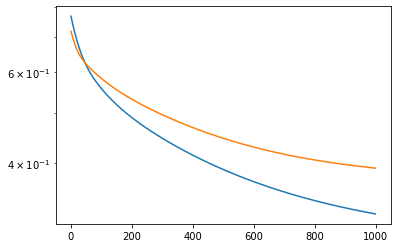

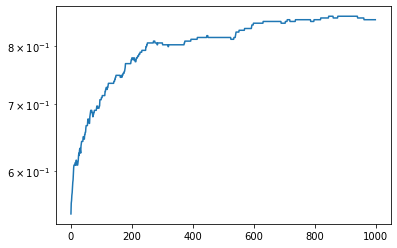

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       236
           1       0.68      0.47      0.55        58

    accuracy                           0.85       294
   macro avg       0.78      0.71      0.73       294
weighted avg       0.84      0.85      0.84       294

f1_score: 0.7306122448979592
loss: 0.39182209968566895


In [61]:
layers = generateLayers(1)
model = nn.Sequential(*layers)

trainAndTestModel(model, torch.optim.Adam(model.parameters(), lr=0.001))

### 2 layers

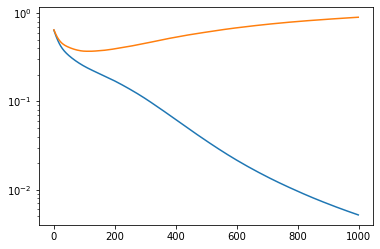

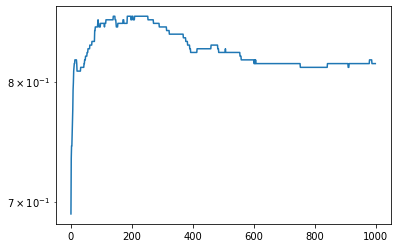

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       236
           1       0.55      0.38      0.45        58

    accuracy                           0.82       294
   macro avg       0.70      0.65      0.67       294
weighted avg       0.80      0.82      0.80       294

f1_score: 0.6693877551020408
loss: 0.8944783210754395


In [58]:
layers = generateLayers(2, nn.ReLU())
model = nn.Sequential(*layers)

trainAndTestModel(model, torch.optim.Adam(model.parameters(), lr=0.001))

### 3 layers

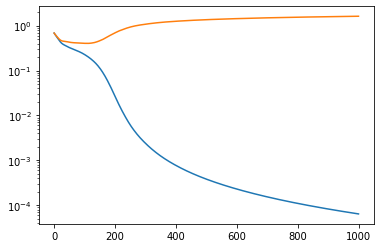

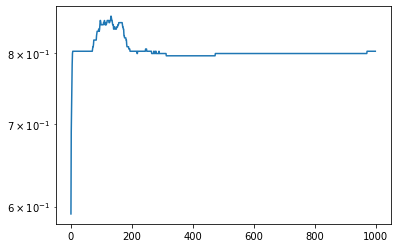

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       236
           1       0.50      0.31      0.38        58

    accuracy                           0.80       294
   macro avg       0.67      0.62      0.63       294
weighted avg       0.78      0.80      0.78       294

f1_score: 0.6327849082608321
loss: 1.6183843612670898


In [62]:
layers = generateLayers(3, nn.ReLU())
model = nn.Sequential(*layers)

trainAndTestModel(model, torch.optim.Adam(model.parameters(), lr=0.001))

### 4 layers

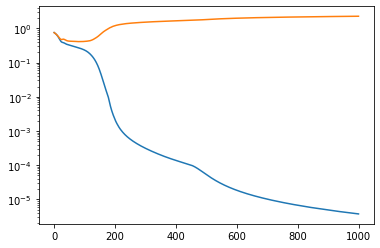

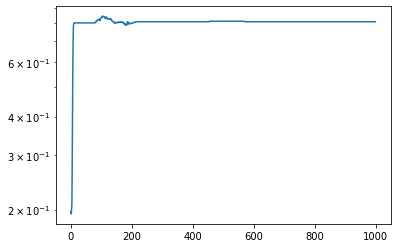

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       236
           1       0.52      0.45      0.48        58

    accuracy                           0.81       294
   macro avg       0.69      0.67      0.68       294
weighted avg       0.80      0.81      0.80       294

f1_score: 0.6824074074074074
loss: 2.2734973430633545


In [63]:
layers = generateLayers(4, nn.ReLU())
model = nn.Sequential(*layers)

trainAndTestModel(model, torch.optim.Adam(model.parameters(), lr=0.001))

## 2.4 Попробуйте различные функции активации

Обучите 4 модели, используя 4 различных функции активации на промежуточных слоях: sigmoid, tanh, ReLU, ELU. На выходном слое в качестве функции активации используйте сигмоиду.

Постройте: 1) график loss для train и test в зависимости от используемой функции активации; 2) график accuracy для train и test в зависимости от используемой функции активации;

### ReLU

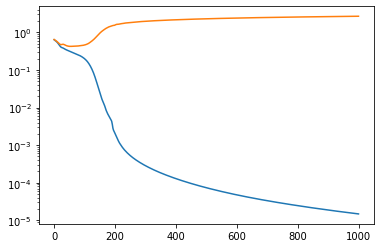

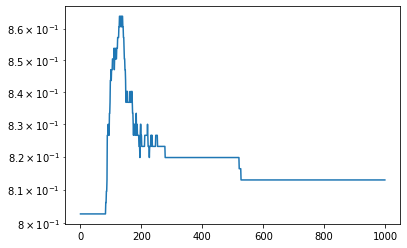

              precision    recall  f1-score   support

           0       0.85      0.92      0.89       236
           1       0.54      0.36      0.43        58

    accuracy                           0.81       294
   macro avg       0.70      0.64      0.66       294
weighted avg       0.79      0.81      0.80       294

f1_score: 0.6604866987213136
loss: 2.6765966415405273


In [67]:
layers = generateLayers(4, nn.ReLU())
model = nn.Sequential(*layers)

trainAndTestModel(model, torch.optim.Adam(model.parameters(), lr=0.001))

### ELU

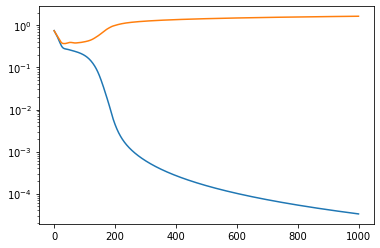

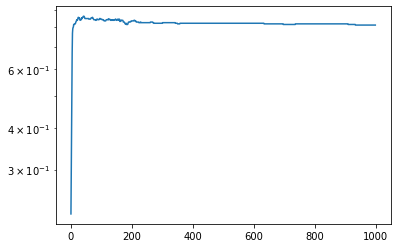

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       236
           1       0.53      0.45      0.49        58

    accuracy                           0.81       294
   macro avg       0.70      0.68      0.69       294
weighted avg       0.80      0.81      0.81       294

f1_score: 0.6858180970330503
loss: 1.6516000032424927


In [69]:
layers = generateLayers(4, nn.ELU())
model = nn.Sequential(*layers)

trainAndTestModel(model, torch.optim.Adam(model.parameters(), lr=0.001))

### Sigmoid

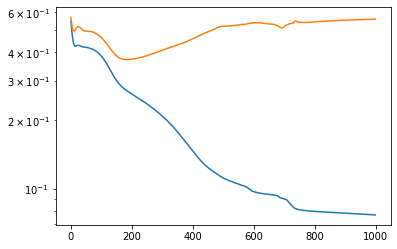

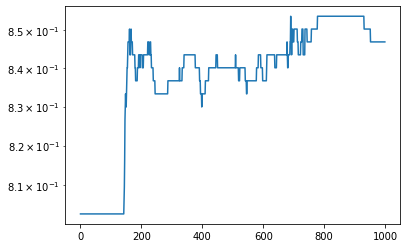

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       236
           1       0.72      0.36      0.48        58

    accuracy                           0.85       294
   macro avg       0.79      0.66      0.70       294
weighted avg       0.83      0.85      0.83       294

f1_score: 0.6964691307041091
loss: 0.5600805282592773


In [70]:
layers = generateLayers(4, nn.Sigmoid())
model = nn.Sequential(*layers)

trainAndTestModel(model, torch.optim.Adam(model.parameters(), lr=0.001))

### tanh

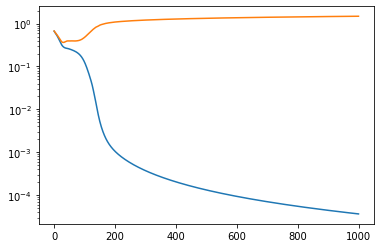

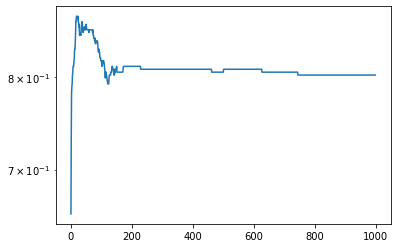

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       236
           1       0.50      0.38      0.43        58

    accuracy                           0.80       294
   macro avg       0.68      0.64      0.66       294
weighted avg       0.79      0.80      0.79       294

f1_score: 0.6560154926167998
loss: 1.4844337701797485


In [71]:
layers = generateLayers(4, nn.Tanh())
model = nn.Sequential(*layers)

trainAndTestModel(model, torch.optim.Adam(model.parameters(), lr=0.001))

## 2.5 Попробуйте различные алгоритмы оптимизации

Обучите 4 модели, используя 4 различных алгоритма оптимизации: SGD, SGD with momentum, RMSprop, Adam

Постройте: 1) график loss для train и test в зависимости от используемого  алгоритма оптимизации; 2) график accuracy для train и test в зависимости от используемого  алгоритма оптимизации.

### Adam

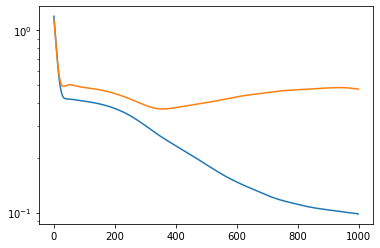

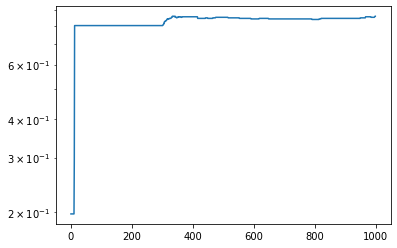

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       236
           1       0.73      0.47      0.57        58

    accuracy                           0.86       294
   macro avg       0.80      0.71      0.74       294
weighted avg       0.85      0.86      0.85       294

f1_score: 0.7426283762143695
loss: 0.47605589032173157


In [84]:
layers = generateLayers(4, nn.Sigmoid())
model = nn.Sequential(*layers)

trainAndTestModel(model, torch.optim.Adam(model.parameters(), lr=0.001))

### RMSprop

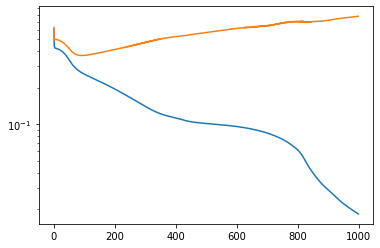

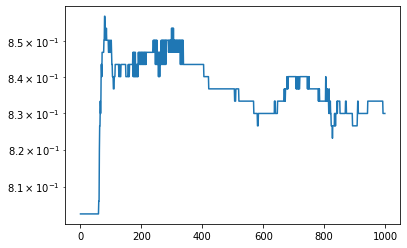

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       236
           1       0.70      0.24      0.36        58

    accuracy                           0.83       294
   macro avg       0.77      0.61      0.63       294
weighted avg       0.81      0.83      0.79       294

f1_score: 0.6304675716440422
loss: 0.7757677435874939


In [73]:
layers = generateLayers(4, nn.Sigmoid())
model = nn.Sequential(*layers)

trainAndTestModel(model, torch.optim.RMSprop(model.parameters(), lr=0.001))

### SGD

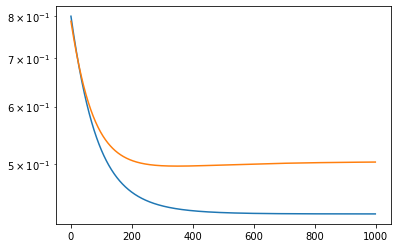

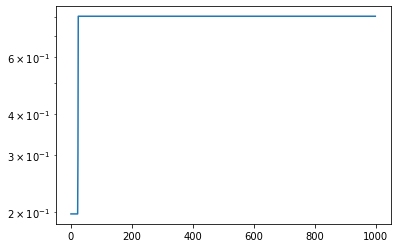

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       236
           1       0.00      0.00      0.00        58

    accuracy                           0.80       294
   macro avg       0.40      0.50      0.45       294
weighted avg       0.64      0.80      0.71       294

f1_score: 0.44528301886792454
loss: 0.5029312372207642


In [74]:
layers = generateLayers(4, nn.Sigmoid())
model = nn.Sequential(*layers)

trainAndTestModel(model, torch.optim.SGD(model.parameters(), lr=0.001))

### SGD with momentum

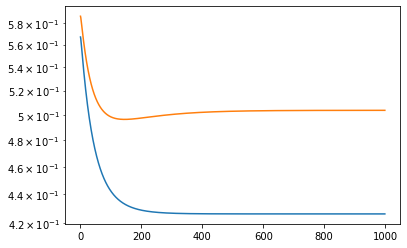

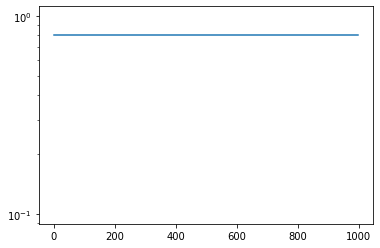

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       236
           1       0.00      0.00      0.00        58

    accuracy                           0.80       294
   macro avg       0.40      0.50      0.45       294
weighted avg       0.64      0.80      0.71       294

f1_score: 0.44528301886792454
loss: 0.5038222670555115


In [75]:
layers = generateLayers(4, nn.Sigmoid())
model = nn.Sequential(*layers)

trainAndTestModel(model, torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.5))

## 2.6 Попробуйте добавить dropout и batch norm

Обучите 5 моделей, используя 5 различных конфигураций: только BatchNorm, только dropout 0.2, только dropout 0.5, BatchNorm + dropout 0.2, BatchNorm + dropout 0.5.

Постройте: 1) график loss для train и test в зависимости от используемой конфигурации; 2) график accuracy для train и test в зависимости от используемой конфигурации.

In [76]:
def generateLayersWithDBN(numLayers, activationFunc= None, batchNorm=55, dropout=0):
    layers = []
    for layer in range(numLayers):
        if layer == numLayers - 1:
            layers.append(nn.Linear(55, 2))
            layers.append(nn.LogSoftmax(dim=1))
        else:
            layers.append(nn.Linear(55, 55))
            if batchNorm:
                layers.append(nn.BatchNorm1d(batchNorm))
            if dropout:
                layers.append(nn.Dropout(p=dropout))
            layers.append(activationFunc)
    
    return layers

### BatchNorm

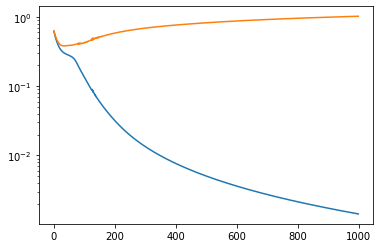

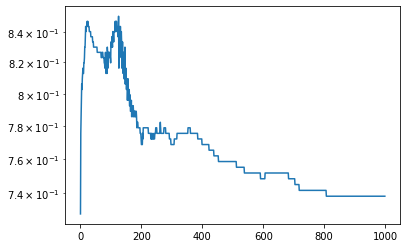

              precision    recall  f1-score   support

           0       0.87      0.80      0.83       236
           1       0.38      0.50      0.43        58

    accuracy                           0.74       294
   macro avg       0.62      0.65      0.63       294
weighted avg       0.77      0.74      0.75       294

f1_score: 0.6298258523424086
loss: 1.0308319330215454


In [77]:
layers = generateLayersWithDBN(4, nn.Sigmoid())
model = nn.Sequential(*layers)

trainAndTestModel(model, torch.optim.Adam(model.parameters(), lr=0.001))

### Dropout = 0.2

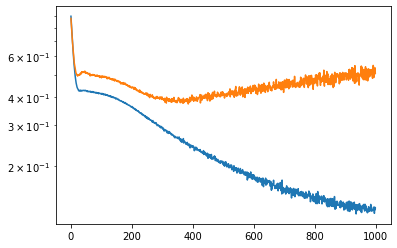

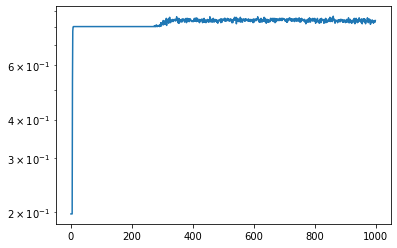

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       236
           1       0.62      0.40      0.48        58

    accuracy                           0.83       294
   macro avg       0.74      0.67      0.69       294
weighted avg       0.82      0.83      0.82       294

f1_score: 0.6924095227927832
loss: 0.5047745108604431


In [79]:
layers = generateLayersWithDBN(4, nn.Sigmoid(), 0, 0.2)
model = nn.Sequential(*layers)

trainAndTestModel(model, torch.optim.Adam(model.parameters(), lr=0.001))

### Dropout = 0.5

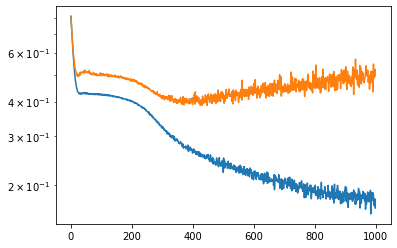

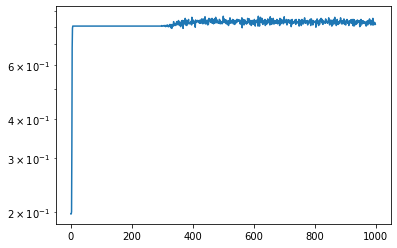

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       236
           1       0.59      0.41      0.48        58

    accuracy                           0.83       294
   macro avg       0.73      0.67      0.69       294
weighted avg       0.81      0.83      0.81       294

f1_score: 0.6902770031604387
loss: 0.5082922577857971


In [82]:
layers = generateLayersWithDBN(4, nn.Sigmoid(), 0, 0.5)
model = nn.Sequential(*layers)

trainAndTestModel(model, torch.optim.Adam(model.parameters(), lr=0.001))

### BatchNorm + dropout = 0.2

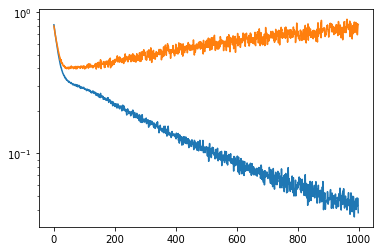

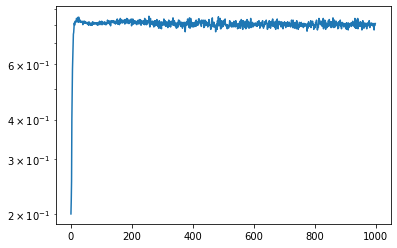

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       236
           1       0.49      0.36      0.42        58

    accuracy                           0.80       294
   macro avg       0.67      0.63      0.65       294
weighted avg       0.78      0.80      0.79       294

f1_score: 0.6473458434139103
loss: 0.8583965301513672


In [81]:
layers = generateLayersWithDBN(4, nn.Sigmoid(), dropout=0.2)
model = nn.Sequential(*layers)

trainAndTestModel(model, torch.optim.Adam(model.parameters(), lr=0.001))

### BatchNorm + dropout = 0.5

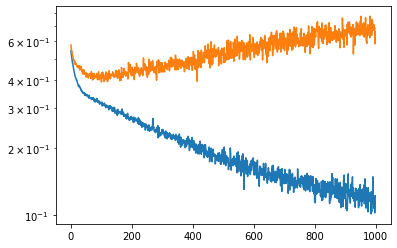

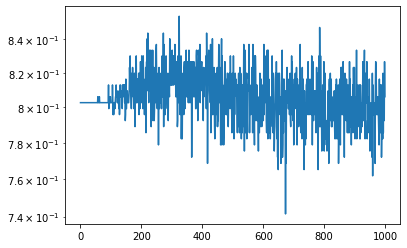

              precision    recall  f1-score   support

           0       0.84      0.92      0.88       236
           1       0.47      0.28      0.35        58

    accuracy                           0.80       294
   macro avg       0.65      0.60      0.61       294
weighted avg       0.77      0.80      0.77       294

f1_score: 0.613429172510519
loss: 0.708439826965332


In [83]:
layers = generateLayersWithDBN(4, nn.Sigmoid(), dropout=0.5)
model = nn.Sequential(*layers)

trainAndTestModel(model, torch.optim.Adam(model.parameters(), lr=0.001))

## 2.7 Постройте финальную модель

Используя информацию, полученную на предыдущих этапах, предложите оптимальную конфигурацию нейронной сети для вашей задачи. Обучите модель.

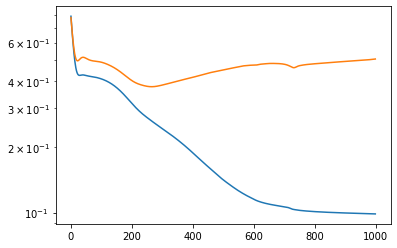

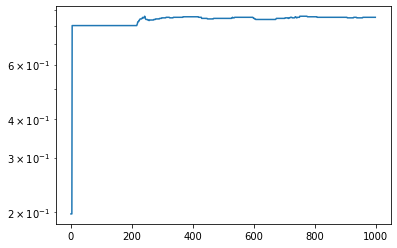

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       236
           1       0.73      0.41      0.53        58

    accuracy                           0.85       294
   macro avg       0.80      0.69      0.72       294
weighted avg       0.84      0.85      0.84       294

f1_score: 0.7204767063921993
loss: 0.5055264234542847


In [87]:
layers = generateLayers(4, nn.Sigmoid())
model = nn.Sequential(*layers)

trainAndTestModel(model, torch.optim.Adam(model.parameters(), lr=0.001))

## 2.8 Выводы

4-ех слойная модель с алгоритмом оптимизации Adam и функцией активацией Sigmoid показала самую высокую точность:
```
f1_score: 0.7426283762143695 
```